# CLUSTER ANALYSIS

I have decided to enrich the informations provided with the *data understaning* by searching for possible 
cluster-like structures in the time series extracted from the main dataset, that is, hoping to discover the 
similarities (or dissimilarities) among the series describing the criminal activities from 2008 to 2016.

I have used three popular clustering algorithms, that is, the 
[KMeans algorithm](https://en.wikipedia.org/wiki/K-means_clustering), the 
[Hierarchical Agglomerative algorithm](https://en.wikipedia.org/wiki/Hierarchical_clustering) and the
[DBSCAN](https://it.wikipedia.org/wiki/Dbscan). 
The three algorithms were adapted depending on the different series they were applied on.

For the analysis of the KMeans and the DBSCAN, being the algorithms unsupervised learning algorithms, I used the 
[silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) for discovering the correct number of
clusters to initialize the KMeans with and the right Eps value to initialize the DBSCAN with, while for the 
analysis of the Hierarchical Agglomerative algorithm I empirically cutted the hierarchy generated by the algorithm at 
a certain height, that is, obtaining a distinct number of clusters. Moreover, in order to obtain a more fine grained 
clustering for the Hierarchical Agglomerative algorithm, I have decided to use two different metrics for evaluating 
the distance among the series, that is, the 
[Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the 
[Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).

### LIBRARIES

In [21]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dtaidistance import clustering, dtw
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 16

### BY-YEAR SERIES CLUSTERING

The first type of time series that I have analysed is the by-year one. This type of data represents the city's 
criminal activities collected on a by-month basis, from January 2008 to December 2016. The criminal activities are 
not divided by borough, major category or minor category, hence obtaining a summary statistics for the yearly amount 
of crimes.

In [42]:
df = pd.read_csv('../data/time_series/ts_total.csv', index_col='date', 
                 parse_dates=True)

In [4]:
ts_by_year_matrix = np.array(
    [df.loc['{}-01-01'.format(year):'{}-12-01'.format(year)].values.
     reshape(1, -1)[0] for year in range(2008, 2017)])

#### HIERARCHICAL AGGLOMERATIVE CLUSTERING

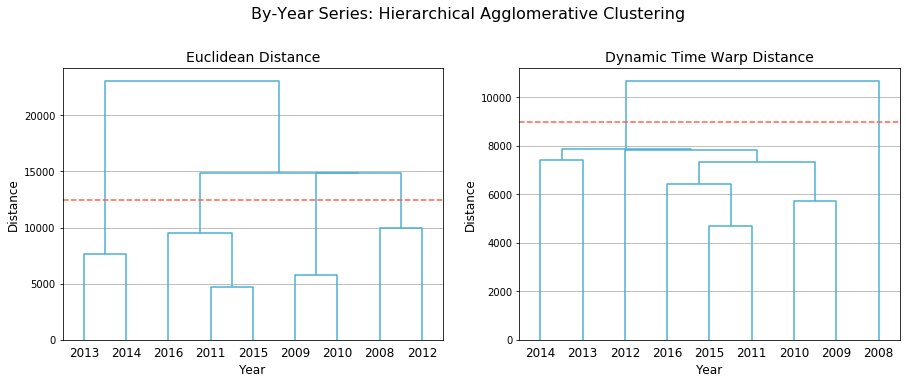

In [5]:
plt.figure(figsize=(15, 5))

plt.suptitle('By-Year Series: Hierarchical Agglomerative Clustering', 
             fontsize=16, y=1.05)

plt.subplot(1, 2, 1)
dendrogram(linkage(ts_by_year_matrix, method='ward', metric='euclidean'), 
           labels=range(2008, 2017), link_color_func=lambda k: '#4bafd1')
plt.axhline(y=12500, color='tomato', linestyle='--')
plt.grid(axis='y')
plt.title('Euclidean Distance', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance', fontsize=12)

plt.subplot(1, 2, 2)
model = clustering.HierarchicalTree(clustering.
                                     Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_year_matrix)
dendrogram(model.linkage, labels=range(2008, 2017),
           link_color_func=lambda k: '#4bafd1')
plt.axhline(y=9000, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='y')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance', fontsize=12)

plt.savefig('../imgs/clustering/by_year_hierarchical.pdf', bbox_inches='tight')

#### SUMMARY

* **Euclidean Distance**: for the Euclidean Distance I have decided to cut at an height of 12500, hence obtaining 3 
clusters composed by couple of series and 1 cluster composed by a triplet of series.
* **Dynamic Time Warping**: for the DTW I have deciced to cut at an height of 9000, hence obtaining only 2 clusters, 
one composed by the series representing the year 2008 and the other containing the remaining series.

#### K-MEANS CLUSTERING

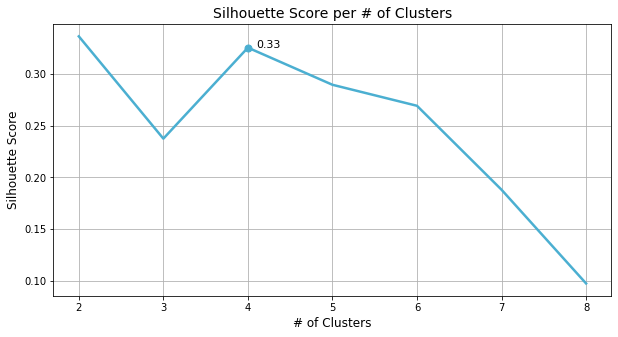

In [6]:
silhouette_scores = []

for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_year_matrix)
    silhouette_scores.append(silhouette_score(ts_by_year_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 7), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[2])
plt.annotate(round(silhouette_scores[2], 2), (2.1, silhouette_scores[2]),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 7), labels=range(2, 9))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_year_series.pdf', bbox_inches='tight')

#### SUMMARY

For the sake of the analysis, the possible number of clusters that were chosen to test the KMeans algorithm range 
from 2 to 8, being the by-year series composed by 9 samples. As we can see, the final number of cluster to initialize 
the KMeans algorithm with is 4. It is not the value returning the highest score though, but it is the one providing, 
in my opinion, the best subdivision for the dataset.

In [5]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=4).fit_predict(ts_by_year_matrix),
                      index=range(2008, 2017), columns=['Cluster'])
kmeans.index.name = 'Year'

kmeans.sort_values('Cluster')

,Cluster
Year,
2011,0
2015,0
2016,0
2008,1
2012,1
2009,2
2010,2
2013,3
2014,3


#### DENSITY BASED CLUSTERING

Text(0, 0.5, 'Silhouette Score')

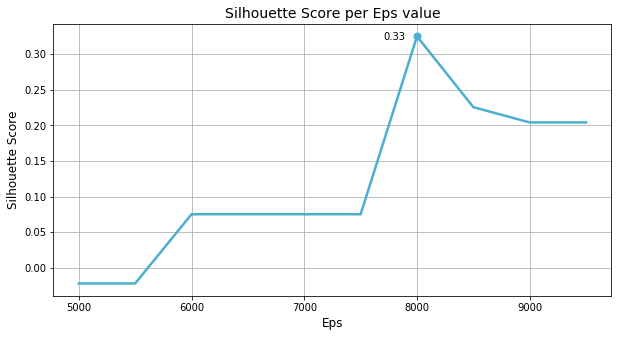

In [8]:
dbscan_trials = {}

for i in range(1000, 10001, 500):
    try:
        dbscan = DBSCAN(eps=i, min_samples=2).fit_predict(ts_by_year_matrix)
        dbscan_trials[i]= silhouette_score(ts_by_year_matrix, dbscan)
    except:
        continue
        
plt.figure(figsize=(10, 5))
plt.plot(list(dbscan_trials.keys()), list(dbscan_trials.values()), 
         linewidth=2.5, color='#4bafd1', marker='o', markersize=7.0, 
         markevery=[6])
plt.annotate(round(dbscan_trials[8000], 2), 
             (7700, dbscan_trials[8000] - 0.005))
plt.grid()
plt.title('Silhouette Score per Eps value')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')

#### SUMMARY

The best value for the silhouette score is obtained by using 8000 as Eps value. Being the dataset small, I decide to
use 2 as value for the min_samples variable, hence obtaining a clustering composed by small clusters (mostly couple 
of series).

In [6]:
dbscan = pd.DataFrame(data=DBSCAN(eps=8000, min_samples=2).fit_predict(ts_by_year_matrix),
                      index=range(2008, 2017), columns=['Cluster'])
dbscan.index.name = 'Year'

dbscan.sort_values('Cluster')

,Cluster
Year,
2008,-1
2012,-1
2009,0
2010,0
2011,1
2015,1
2016,1
2013,2
2014,2


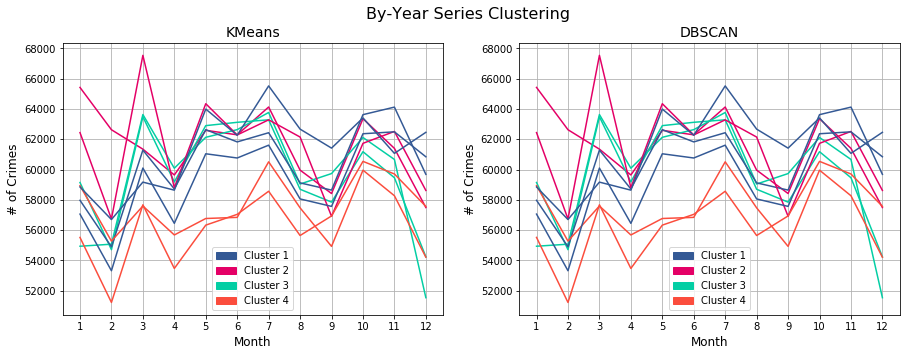

In [53]:
c1, c2, c3, c4 = '#345995', '#E40066', '#03CEA4', '#FB4D3D'
plt.figure(figsize=(15, 5))

plt.suptitle('By-Year Series Clustering')

plt.subplot(1, 2, 1)

for i in range(0, 9):
    color = ''
    
    if i in [3, 7, 8]:
        color = c1
    elif i in [0, 4]:
        color = c2
    elif i in [1, 2]:
        color = c3
    else:
        color = c4
    
    plt.plot(ts_by_year_matrix[i], color=color)

plt.grid()
plt.xticks(range(0, 12), range(1, 13))
plt.title('KMeans')
plt.xlabel('Month')
plt.ylabel('# of Crimes')
plt.legend(handles=[mpatches.Patch(color=c1, label='Cluster 1'),
                    mpatches.Patch(color=c2, label='Cluster 2'),
                    mpatches.Patch(color=c3, label='Cluster 3'),
                    mpatches.Patch(color=c4, label='Cluster 4')])

plt.subplot(1, 2, 2)

for i in range(0, 9):
    color = ''
    
    if i in [3, 7, 8]:
        color = c1
    elif i in [0, 4]:
        color = c2
    elif i in [1, 2]:
        color = c3
    else:
        color = c4
    
    plt.plot(ts_by_year_matrix[i], color=color)

plt.grid()
plt.xticks(range(0, 12), range(1, 13))
plt.title('DBSCAN')
plt.xlabel('Month')
plt.ylabel('# of Crimes')
plt.legend(handles=[mpatches.Patch(color=c1, label='Cluster 1'),
                    mpatches.Patch(color=c2, label='Cluster 2'),
                    mpatches.Patch(color=c3, label='Cluster 3'),
                    mpatches.Patch(color=c4, label='Cluster 4')])

plt.savefig('../imgs/clustering/by_year_comparison.pdf',
           bbox_inches='tight')

### BY-BOROUGH SERIES CLUSTERING

The next type of time series that I have analysed is the by-borough one. This type of data represents the city's 
criminal activities collected on a by-borough basis. The dataset contains, for each one of the 33 boroughs, the 
monthly reports for the criminal activities registered in the window of time that ranges from 2008 to 2016. The 
crimes are not divided by category, hence providing a summary statistics for each one of the boroughs.

In [38]:
df = pd.read_csv('../data/time_series/ts_borough.csv', index_col='date', 
                 parse_dates=True)

In [39]:
ts_by_borough_matrix = np.array(
    [df[df['borough'] == b].sort_index()['value'].values 
     for b in df['borough'].unique()])

#### HIERARCHICAL AGGLOMERATIVE CLUSTERING

In [5]:
model = clustering.HierarchicalTree(clustering.
                                    Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_borough_matrix)

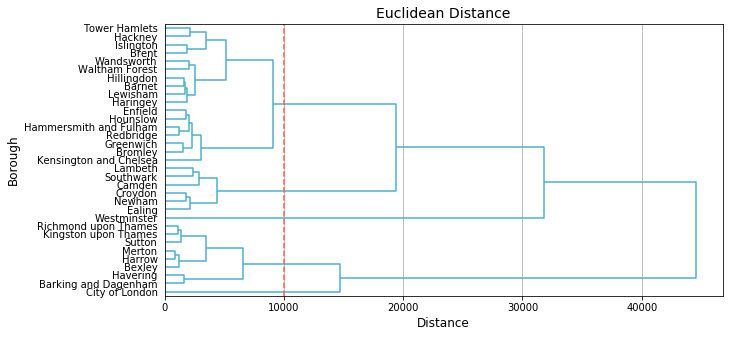

In [9]:
plt.figure(figsize=(10, 5))

#plt.suptitle('By-Borough Series: Hierarchical Agglomerative Clustering', 
#             fontsize=16, va='center', ha='center', y=0.95)

#plt.subplot(2, 1, 1)
dendrogram(linkage(ts_by_borough_matrix, method='ward', metric='euclidean'), 
           labels=df['borough'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=10000, color='tomato', linestyle='--')
plt.title('Euclidean Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Borough', fontsize=12)

plt.savefig('../imgs/clustering/by_borough_hierarchical_euclidean.pdf', 
            bbox_inches='tight')

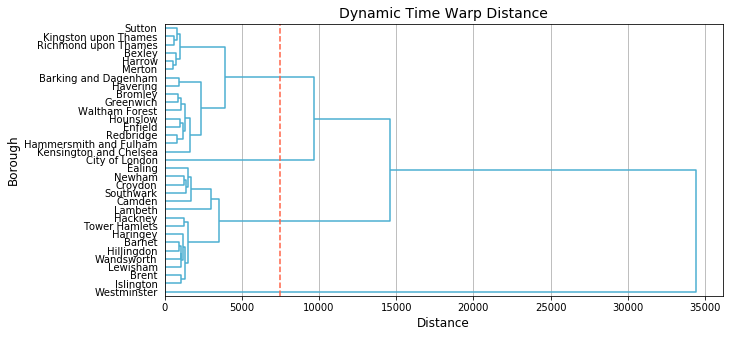

In [10]:
plt.figure(figsize=(10, 5))

dendrogram(model.linkage, labels=df['borough'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=7500, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Borough', fontsize=12)

plt.savefig('../imgs/clustering/by_borough_hierarchical_dtw.pdf', 
            bbox_inches='tight')

#### SUMMARY

* **Euclidean Distance**: for the Euclidean Distance I have decided to cut at an height of 10000, hence obtaining 5 
clusters.
* **Dynamic Time Warping**: for the DTW I have deciced to cut at an height of 7500, hence obtaining 4 clusters.

For both the two metrics we can immediately see that Westminster, that is, the borough with the highest number of 
criminal activities, form a cluster by itself. This confirms the borough as the most dangerous among all the 
boroughs composing the city of London. On the opposite, we can see as the same happens for City of London, that is, 
the least dangerous. The remaining boroughs are clustered together in a pretty similar fashion by both the 
Euclidean Distance and the Dynamic Time Warping.

#### K-MEANS CLUSTERING

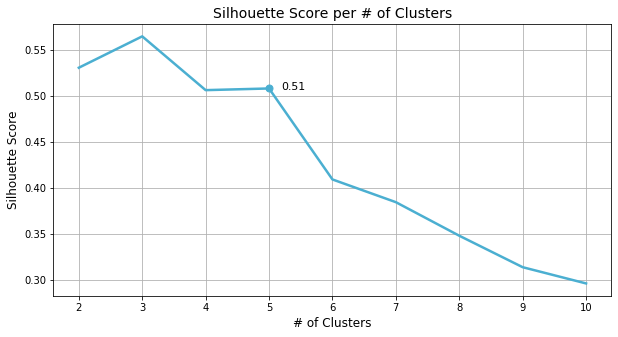

In [14]:
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_borough_matrix)
    silhouette_scores.append(silhouette_score(ts_by_borough_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 9), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[3])
plt.annotate(round(silhouette_scores[3], 2), (3.2, silhouette_scores[2]),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 9), labels=range(2, 11))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_borough_series.pdf', bbox_inches='tight')

#### SUMMARY

Being the dataset composed by 33 samples, I decided to push a little farther the analysis for the KMeans algorithm, 
by choosing to search for the best number of cluster to initialized the algorithm with in range from 2 to 11. Once
again, the value I have chosen, that is, 5, is not the highest considering the silhouette score, but, in my 
opinion, gives a better representation of the relationships among the series composing the dataset.

In [15]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=5).fit_predict(ts_by_borough_matrix),
                      index=df['borough'].unique(), columns=['Cluster'])
kmeans.index.name = 'Borough'

kmeans.sort_values('Cluster')

,Cluster
Borough,
Brent,0
Kensington and Chelsea,0
Barnet,0
Haringey,0
Tower Hamlets,0
Hillingdon,0
Lewisham,0
Waltham Forest,0
Hounslow,0


#### DENSITY BASED CLUSTERING

Text(0, 0.5, 'Silhouette Score')

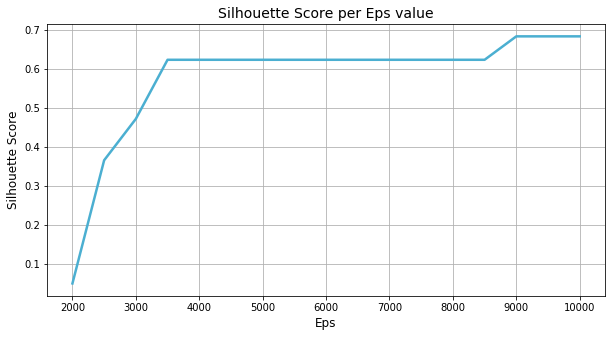

In [16]:
dbscan_trials = {}

for i in range(0, 10001, 500):
    try:
        dbscan = DBSCAN(eps=i, min_samples=5).fit_predict(ts_by_borough_matrix)
        dbscan_trials[i]= silhouette_score(ts_by_borough_matrix, dbscan)
    except:
        continue

plt.figure(figsize=(10, 5))
plt.plot(list(dbscan_trials.keys()), list(dbscan_trials.values()), 
         linewidth=2.5, color='#4bafd1')
plt.grid()
plt.title('Silhouette Score per Eps value')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')

#### SUMMARY

By choosing the value 3200 for Eps the algorithm is able to isolate both City of London and Westminster, being the
former the least dangerous borough and the latter the most dangerous. The other boroughs are contained in two 
distinct clusters.

In [17]:
dbscan = pd.DataFrame(data=DBSCAN(eps=3200, min_samples=5).fit_predict(ts_by_borough_matrix),
                      index=df['borough'].unique(), columns=['Cluster'])
dbscan.index.name = 'Borough'

dbscan.sort_values('Cluster')

,Cluster
Borough,
City of London,-1
Westminster,-1
Merton,0
Harrow,0
Richmond upon Thames,0
Havering,0
Kingston upon Thames,0
Sutton,0
Barking and Dagenham,0


### BY-MAJOR CATEGORY SERIES CLUSTERING

The last time series is the by-major category one. This serie collects monthly reports on the criminal activities
divided by major category, hence providing, for each category, the number of crimes from January 2008 to December
2016, collected on a by-month basis.

In [37]:
df = pd.read_csv('../data/time_series/ts_major_cat.csv', index_col='date', 
                 parse_dates=True)

In [30]:
ts_by_major_cat_matrix = np.array(
    [df[df['major_category'] == mc].sort_index()['value'].values 
     for mc in df['major_category'].unique()])

#### HIERARCHICAL AGGLOMERATIVE CLUSTERING

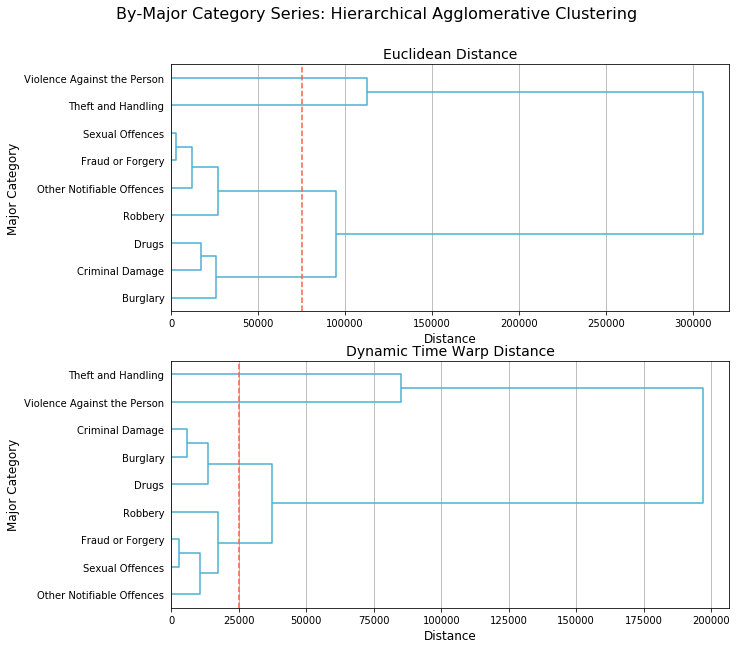

In [20]:
plt.figure(figsize=(10, 10))

plt.suptitle('By-Major Category Series: Hierarchical Agglomerative Clustering', 
             fontsize=16, va='center', ha='center', x=0.41, y=0.95)

plt.subplot(2, 1, 1)
dendrogram(linkage(ts_by_major_cat_matrix, method='ward', metric='euclidean'), 
           labels=df['major_category'].unique(), orientation='right', 
           leaf_font_size=10, link_color_func=lambda k: '#4bafd1')
plt.axvline(x=75000, color='tomato', linestyle='--')
plt.title('Euclidean Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Major Category', fontsize=12)

plt.subplot(2, 1, 2)
model = clustering.HierarchicalTree(clustering.
                                    Hierarchical(dtw.distance_matrix, {}))
cluster_idx = model.fit(ts_by_major_cat_matrix)
dendrogram(model.linkage, labels=df['major_category'].unique(), 
           orientation='right', leaf_font_size=10, 
           link_color_func=lambda k: '#4bafd1')
plt.axvline(x=25000, color='tomato', linestyle='--')
plt.title('Dynamic Time Warp Distance', fontsize=14)
plt.grid(axis='x')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Major Category', fontsize=12)

plt.savefig('../imgs/clustering/by_major_category_hierarchical.pdf',
            bbox_inches='tight')

#### SUMMARY

* **Euclidean Distance**: for the Euclidean Distance I have decided to cut at an height of 75000, hence obtaining 4 
clusters.
* **Dynamic Time Warping**: for the DTW I have deciced to cut at an height of 25000, hence obtaining 4 clusters.

Both the two metrics isolate Theft and Handling, that is, the most popular major category, in a cluster by itself. 
The same happens for Violence Against the Person, that is, the second most popular major category. The clustering
for the remaining major categories is the same for the two metrics.

#### K-MEANS CLUSTERING

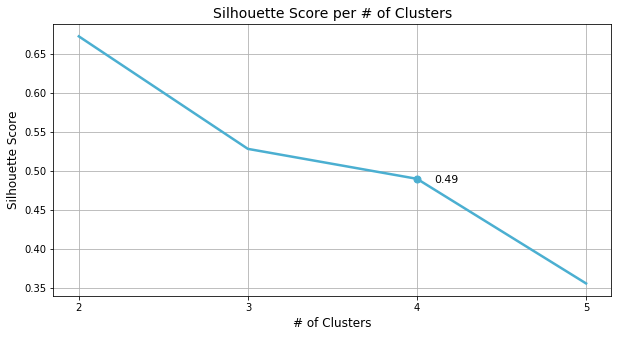

In [21]:
silhouette_scores = []

for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters).fit(ts_by_major_cat_matrix)
    silhouette_scores.append(silhouette_score(ts_by_major_cat_matrix, 
                                              kmeans.labels_))
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, 4), silhouette_scores, color='#4bafd1', linewidth=2.5,
         marker='o', markersize=7.0, markevery=[2])
plt.annotate(round(silhouette_scores[2], 2), (2.1, 
                                              silhouette_scores[2] - 0.005),
             fontsize=11)
plt.grid()
plt.xticks(ticks=range(0, 4), labels=range(2, 6))
plt.xlabel('# of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per # of Clusters', fontsize=14)
plt.savefig('../imgs/clustering/sc_by_major_cat_series.pdf', 
            bbox_inches='tight')

#### SUMMARY

Being the dataset composed by only 9 samples I have decided to search for the best number of clusters in a range that
goes from 2 to 6, finally choosing 4 as best number of clusters to initialize the KMeans algorithm with.

In [5]:
kmeans = pd.DataFrame(data=KMeans(n_clusters=4).fit_predict(ts_by_major_cat_matrix),
                      index=df['major_category'].unique(), columns=['Cluster'])
kmeans.index.name = 'Major Category Crime'

kmeans.sort_values('Cluster')

,Cluster
Major Category Crime,
Robbery,0
Fraud or Forgery,0
Sexual Offences,0
Other Notifiable Offences,0
Theft and Handling,1
Violence Against the Person,2
Criminal Damage,3
Burglary,3
Drugs,3


#### DENSITY BASED CLUSTERING

Text(0, 0.5, 'Silhouette Score')

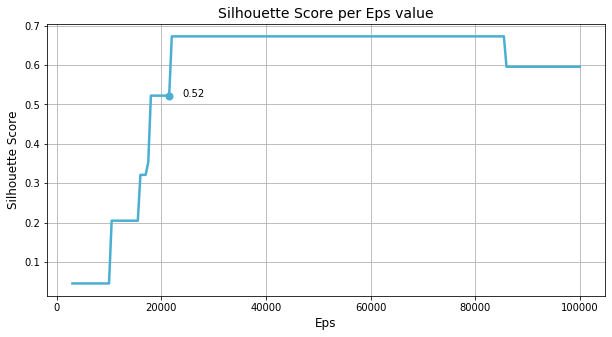

In [23]:
dbscan_trials = {}

for i in range(0, 100001, 500):
    try:
        dbscan = DBSCAN(eps=i, min_samples=2).fit_predict(ts_by_major_cat_matrix)
        dbscan_trials[i] = silhouette_score(ts_by_major_cat_matrix, dbscan)
    except:
        continue

plt.figure(figsize=(10, 5))
plt.plot(list(dbscan_trials.keys()), list(dbscan_trials.values()), 
         linewidth=2.5, color='#4bafd1', marker='o', markersize=7.0, 
         markevery=[37])
plt.annotate(round(dbscan_trials[21500], 2), (24000, 0.52))
plt.grid()
plt.title('Silhouette Score per Eps value')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')

With 21500 as the value chosen for Eps the algorithm returns a clustering that mimics the distribution of criminal
activities per major category as showed during the data understanding.

In [24]:
dbscan = pd.DataFrame(data=DBSCAN(eps=21500, min_samples=2).fit_predict(ts_by_major_cat_matrix),
                      index=df['major_category'].unique(), columns=['Cluster'])
dbscan.index.name = 'Major Category'

dbscan.sort_values('Cluster')

,Cluster
Major Category,
Theft and Handling,-1
Violence Against the Person,-1
Criminal Damage,0
Burglary,0
Drugs,0
Robbery,1
Fraud or Forgery,1
Sexual Offences,1
Other Notifiable Offences,1


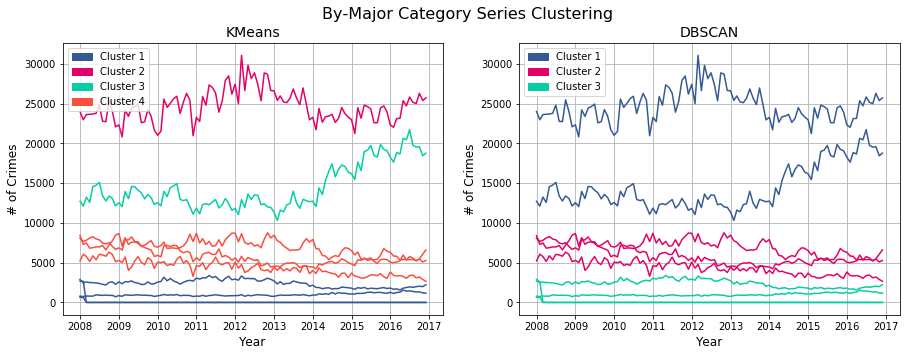

In [54]:
plt.figure(figsize=(15, 5))

plt.suptitle('By-Major Category Series Clustering')

plt.subplot(1, 2, 1)

for i in range(0, 9):
    color = ''
    
    if i in [4, 6, 7, 8]:
        color = c1
    elif i in [0]:
        color = c2
    elif i in [3]:
        color = c3
    else:
        color = c4
    
    plt.plot(pd.date_range(start='01/01/2008', end='12/01/2016', freq='MS'),
             ts_by_major_cat_matrix[i], color=color)

plt.grid()
#plt.xticks(range(0, 12), range(1, 13))
plt.title('KMeans')
plt.xlabel('Year')
plt.ylabel('# of Crimes')
plt.legend(handles=[mpatches.Patch(color=c1, label='Cluster 1'),
                    mpatches.Patch(color=c2, label='Cluster 2'),
                    mpatches.Patch(color=c3, label='Cluster 3'),
                    mpatches.Patch(color=c4, label='Cluster 4')])

plt.subplot(1, 2, 2)

for i in range(0, 9):
    color = ''
    
    if i in [0, 3]:
        color = c1
    elif i in [1, 2, 5]:
        color = c2
    else:
        color = c3
    
    plt.plot(pd.date_range(start='01/01/2008', end='12/01/2016', freq='MS'),
             ts_by_major_cat_matrix[i], color=color)

plt.grid()
#plt.xticks(range(0, 12), range(1, 13))
plt.title('DBSCAN')
plt.xlabel('Year')
plt.ylabel('# of Crimes')
plt.legend(handles=[mpatches.Patch(color=c1, label='Cluster 1'),
                    mpatches.Patch(color=c2, label='Cluster 2'),
                    mpatches.Patch(color=c3, label='Cluster 3')])

plt.savefig('../imgs/clustering/by_major_category_comparison.pdf',
           bbox_inches='tight')